# PROJET 4
# MODELISATION CIBLE 1
***

## 1 - PREPROCESSING
***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
import xgboost as xgb

In [3]:
#On importe les dataframes issus de notre nettoyage

data_energy = pd.read_csv('data/data_energy.csv')
data_energystar = pd.read_csv('data/data_energystar.csv')

In [4]:
data_energy.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,SiteEnergyUse(kBtu),ElectricityProp,SteamProp,GasProp,Age,BuildingArea,ParkingArea,LargestUsedArea,SecondLargestUsedArea
0,Hotel,DOWNTOWN,1.0,88434,Hotel,NONE,7226362.5,0.546060,0.277302,0.176638,89,1.000000,0.000000,1.000000,0.000000
1,Hotel,DOWNTOWN,1.0,103566,Hotel,Parking,8387933.0,0.386609,0.000000,0.613391,20,0.854547,0.145453,0.809918,0.145453
2,Hotel,DOWNTOWN,1.0,956110,Hotel,NONE,72587024.0,0.682307,0.297113,0.020579,47,0.794252,0.205748,0.791220,0.000000
3,Hotel,DOWNTOWN,1.0,61320,Hotel,NONE,6794584.0,0.407519,0.325913,0.266567,90,1.000000,0.000000,1.000000,0.000000
4,Hotel,DOWNTOWN,1.0,175580,Hotel,Parking,14172606.0,0.378802,0.000000,0.621198,36,0.646885,0.353115,0.703070,0.387339


In [5]:
data_energystar.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),ElectricityProp,SteamProp,GasProp,Age,BuildingArea,ParkingArea,LargestUsedArea,SecondLargestUsedArea
0,Hotel,DOWNTOWN,1.0,88434,Hotel,NONE,60.0,7226362.5,0.546060,0.277302,0.176638,89,1.000000,0.000000,1.000000,0.000000
1,Hotel,DOWNTOWN,1.0,103566,Hotel,Parking,61.0,8387933.0,0.386609,0.000000,0.613391,20,0.854547,0.145453,0.809918,0.145453
2,Hotel,DOWNTOWN,1.0,956110,Hotel,NONE,43.0,72587024.0,0.682307,0.297113,0.020579,47,0.794252,0.205748,0.791220,0.000000
3,Hotel,DOWNTOWN,1.0,61320,Hotel,NONE,56.0,6794584.0,0.407519,0.325913,0.266567,90,1.000000,0.000000,1.000000,0.000000
4,Hotel,DOWNTOWN,1.0,175580,Hotel,Parking,75.0,14172606.0,0.378802,0.000000,0.621198,36,0.646885,0.353115,0.703070,0.387339


In [6]:
#Au revoir le CAPS

data_energy.loc[data_energy['SecondLargestPropertyUseType'] == 'NONE', 'SecondLargestPropertyUseType'] = 'None'
data_energystar.loc[data_energystar['SecondLargestPropertyUseType'] == 'NONE', 'SecondLargestPropertyUseType'] = 'None'

In [8]:
#Vérification qu'il n'y ait bien aucune valeur manquante

print('-' * 40)
print("VALEURS MANQUANTES")
print('-' * 40)
print('data_energy :', data_energy.isna().mean().mean().round())
print('data_energystar :' , data_energystar.isna().mean().mean().round())
print('_'*40)

----------------------------------------
VALEURS MANQUANTES
----------------------------------------
data_energy : 0.0
data_energystar : 0.0
________________________________________


In [14]:
#On sépare les features de la cible

X = data_energy.drop(columns = ['SiteEnergyUse(kBtu)'])
y = data_energy['SiteEnergyUse(kBtu)']


#Idem pour data_energystar

X_star = data_energystar.drop(columns = ['SiteEnergyUse(kBtu)'])
y_star = data_energystar['SiteEnergyUse(kBtu)']

In [16]:
#On sépare nos jeux de données en un jeu d'entraînement et un jeu de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size = 0.2, random_state = 42)

In [18]:
#On affiche les dimensions de nos jeux d'entrainement

print('-'*30)
print("JEUX D'ENTRAINEMENT")
print('-'*30)
print("X_train :", X_train.shape[0])
print("X_star_train :", X_star_train.shape[0])

------------------------------
JEUX D'ENTRAINEMENT
------------------------------
X_train : 1233
X_star_train : 795


In [20]:
#Idem avec nos jeux de test

print('-'*30)
print("JEUX DE TEST")
print('-'*30)
print("X_test :", X_test.shape[0])
print("X_star_test :", X_star_test.shape[0])

------------------------------
JEUX DE TEST
------------------------------
X_test : 309
X_star_test : 199


In [22]:
#On différencie les variables numériques des catégorielles.

numerical_features = make_column_selector(dtype_include = np.number)
categorical_features = make_column_selector(dtype_exclude = np.number)

In [24]:
#On encode les variables catégorielles et on normalise les features numériques

numerical_pipeline_stdscl = Pipeline(steps = [('scaler', StandardScaler())])
categorical_pipeline_ohenc = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [26]:
#On crée deux preprocesseurs pour créer notre pipeline finale (un ou les données numériques sont normalisées et l'autre non)

preprocessor_stdscl = ColumnTransformer(transformers = [
    ('num', numerical_pipeline_stdscl, numerical_features),
    ('cat', categorical_pipeline_ohenc, categorical_features)
])

preprocessor_base = ColumnTransformer(transformers = [
    ('cat', categorical_pipeline_ohenc, categorical_features)
])

In [28]:
#Une fonction qui retourne un booléen si notre modèle normalise les features numériques

def is_normalized(pipeline):
   
    for step_name, transformer in pipeline.steps:
        if isinstance(transformer, ColumnTransformer):
            for transformer_name, sub_transformer, _ in transformer.transformers:
                if isinstance(sub_transformer, Pipeline):
                    for sub_step_name, sub_step_transformer in sub_transformer.steps:
                        if 'scaler' in str(sub_step_name).lower():
                            return True
                elif 'scaler' in str(transformer_name).lower():
                    return True
    return False

In [30]:
#On crée un dataframe dans lequel on stockera nos résultats.

columns_models = ['MODELE', 'STANDARD SCALER', 'ENERGYSTAR', 'CV R2', 'CV RMSE', 'CV MAE', 'R2', 'RMSE', 'MAE']
data_models = pd.DataFrame(columns = columns_models)

In [32]:
#Création d'une fonction pour entrainer nos modèles


def run_model(model, name, X_train, y_train, X_test, y_test, cv = 5, use_grid_search = False, param_grid = None, scoring = None, starscore = False):
    
    normalized = 'OUI' if is_normalized(model) else 'NON'
    ess = 'OUI' if starscore else 'NON' 
    
    
    #Dans le cas d'un GridSearchCV
    
    if use_grid_search == True:
        
        #On instancie notre grille de recherche et on l'ajuste
        grid_search = GridSearchCV(model, param_grid, cv = cv, scoring = scoring, n_jobs = -1)
        grid_search.fit(X_train, y_train)
        
        #On sélectionne le modèle avec les meilleurs paramètres
        best_model = grid_search.best_estimator_
          
        #On sort les scores de validation croisée
        cv_r2 = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="r2", n_jobs = -1).mean()
        cv_rmse = -cross_val_score(best_model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1).mean()
        cv_mae = -cross_val_score(best_model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error", n_jobs = -1).mean()
        
        #On l'entraîne
        best_model.fit(X_train, y_train)
        
        #On prédit
        y_pred = best_model.predict(X_test)
    
    #Si pas de paramètres à rechercher
    
    else:
        #On sort les scores de validation croisée
        cv_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2", n_jobs = -1).mean()
        cv_rmse = -cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1).mean()
        cv_mae = -cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error", n_jobs = -1).mean()
        
        #On l'entraîne
        model.fit(X_train, y_train)
        
        #On prédit
        y_pred = model.predict(X_test)
    
    
    #On calcule les scores
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results = [name, normalized, ess, cv_r2, cv_rmse, cv_mae, r2, rmse, mae]
    
    #On ajoute les résultats au dataframe data_models
    #print(results)
    global data_models
    data_models.loc[len(data_models)] = results
    
    return data_models                                      

## 2 - REGRESSION LINEAIRE
***

In [35]:
#On test deux modèles de régression linéaire. Un sur les données normalisées et l'autre sur les données non normalisées.

linear_model_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', LinearRegression())
])

linear_model_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', LinearRegression())
])

In [37]:
#On fait passer les modèles dans notre fonction

run_model(linear_model_base, 'Linear Regression', X_train, y_train, X_test, y_test, cv = 5, use_grid_search=False, param_grid=None, scoring=None, starscore=False)
run_model(linear_model_std, 'Linear Regression', X_train, y_train, X_test, y_test, cv = 5, use_grid_search=False, param_grid=None, scoring=None, starscore=False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06


In [38]:
#Idem avec ENERGYSTARScore cette fois 

#On fait passer les modèles dans notre fonction

run_model(linear_model_base, 'Linear Regression', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search=False, param_grid=None, scoring=None, starscore=True)
run_model(linear_model_std, 'Linear Regression', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search=False, param_grid=None, scoring=None, starscore=True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07


## 3 - REGRESSION RIDGE
***

In [40]:
#On définit nos modèles

ridge_model_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', Ridge())
])

ridge_model_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', Ridge())
])

#Creation d'une grille de recherche

ridge_alpha_grid = {'regressor__alpha': [0.1, 0.5, 1, 5, 10, 20, 50, 100]}

In [44]:
#On run la fonction

run_model(ridge_model_base, 'Ridge Regression', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = ridge_alpha_grid, scoring = 'r2', starscore = False)
run_model(ridge_model_std, 'Ridge Regression', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = ridge_alpha_grid, scoring = 'r2', starscore = False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07
4,Ridge Regression,NON,NON,0.282329,1.459731e+07,6.925750e+06,0.016891,5.781000e+07,1.042207e+07
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06


In [45]:
#Et avec ENERGYSTARScore

run_model(ridge_model_base, 'Ridge Regression', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = ridge_alpha_grid, scoring = 'r2', starscore = True)
run_model(ridge_model_std, 'Ridge Regression', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = ridge_alpha_grid, scoring = 'r2', starscore = True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07
4,Ridge Regression,NON,NON,0.282329,1.459731e+07,6.925750e+06,0.016891,5.781000e+07,1.042207e+07
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06
6,Ridge Regression,NON,OUI,0.193259,1.992638e+07,7.058071e+06,0.254895,2.730223e+07,9.136780e+06
7,Ridge Regression,OUI,OUI,0.533433,1.451400e+07,4.783880e+06,0.443686,2.359117e+07,6.520198e+06


## 4 - FORETS ALEATOIRES
***

In [48]:
#On initialise nos modèles

rfr = RandomForestRegressor(random_state = 42)

model_rfr_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', rfr)
])    

model_rfr_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', rfr)
])


#Création d'une grille de recherche

rfr_n_grid = {'regressor__n_estimators': [x for x in range(100, 1500, 100)]}

In [50]:
#On évalue les modèles 

run_model(model_rfr_base, 'Random Forest', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = rfr_n_grid, scoring = 'r2', starscore = False)
run_model(model_rfr_std, 'Random Forest', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = rfr_n_grid, scoring = 'r2', starscore = False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07
4,Ridge Regression,NON,NON,0.282329,1.459731e+07,6.925750e+06,0.016891,5.781000e+07,1.042207e+07
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06
6,Ridge Regression,NON,OUI,0.193259,1.992638e+07,7.058071e+06,0.254895,2.730223e+07,9.136780e+06
7,Ridge Regression,OUI,OUI,0.533433,1.451400e+07,4.783880e+06,0.443686,2.359117e+07,6.520198e+06
8,Random Forest,NON,NON,0.179772,1.487364e+07,6.152110e+06,-0.005607,5.846775e+07,9.913164e+06
9,Random Forest,OUI,NON,0.605140,1.064898e+07,3.866342e+06,0.197569,5.222831e+07,7.188923e+06


In [52]:
#De même en prenant en compte ENERGYSTARScore

run_model(model_rfr_base, 'Random Forest', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = rfr_n_grid, scoring = 'r2', starscore = True)
run_model(model_rfr_std, 'Random Forest', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = rfr_n_grid, scoring = 'r2', starscore = True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07
4,Ridge Regression,NON,NON,0.282329,1.459731e+07,6.925750e+06,0.016891,5.781000e+07,1.042207e+07
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06
6,Ridge Regression,NON,OUI,0.193259,1.992638e+07,7.058071e+06,0.254895,2.730223e+07,9.136780e+06
7,Ridge Regression,OUI,OUI,0.533433,1.451400e+07,4.783880e+06,0.443686,2.359117e+07,6.520198e+06
8,Random Forest,NON,NON,0.179772,1.487364e+07,6.152110e+06,-0.005607,5.846775e+07,9.913164e+06
9,Random Forest,OUI,NON,0.605140,1.064898e+07,3.866342e+06,0.197569,5.222831e+07,7.188923e+06


## 5 - GRADIENT BOOSTING
***

In [54]:
#On initialise nos modèles

gb = GradientBoostingRegressor(random_state = 42)

model_gb_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', gb)
])

model_gb_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', gb)
])


#Création de la grille de recherche

gb_grid = {
    'regressor__n_estimators': [100, 200, 300, 500, 700],         # Nombre d'estimateurs à tester
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],           # Taux d'apprentissage à tester
    'regressor__max_depth': [2, 3, 4, 5, 6]                       # Profondeur maximale de l'arbre à tester
}

In [55]:
#On évalue les modèles

run_model(model_gb_base, 'Gradient Boosting', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = gb_grid, scoring = 'r2', starscore = False)
run_model(model_gb_std, 'Gradient Boosting', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = gb_grid, scoring = 'r2', starscore = False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07
4,Ridge Regression,NON,NON,0.282329,1.459731e+07,6.925750e+06,0.016891,5.781000e+07,1.042207e+07
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06
6,Ridge Regression,NON,OUI,0.193259,1.992638e+07,7.058071e+06,0.254895,2.730223e+07,9.136780e+06
7,Ridge Regression,OUI,OUI,0.533433,1.451400e+07,4.783880e+06,0.443686,2.359117e+07,6.520198e+06
8,Random Forest,NON,NON,0.179772,1.487364e+07,6.152110e+06,-0.005607,5.846775e+07,9.913164e+06
9,Random Forest,OUI,NON,0.605140,1.064898e+07,3.866342e+06,0.197569,5.222831e+07,7.188923e+06


In [56]:
#De même en prenant en compte ENERGYSTARScore

run_model(model_gb_base, 'Gradient Boosting', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = gb_grid, scoring = 'r2', starscore = True)
run_model(model_gb_std, 'Gradient Boosting', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = gb_grid, scoring = 'r2', starscore = True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07
4,Ridge Regression,NON,NON,0.282329,1.459731e+07,6.925750e+06,0.016891,5.781000e+07,1.042207e+07
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06
6,Ridge Regression,NON,OUI,0.193259,1.992638e+07,7.058071e+06,0.254895,2.730223e+07,9.136780e+06
7,Ridge Regression,OUI,OUI,0.533433,1.451400e+07,4.783880e+06,0.443686,2.359117e+07,6.520198e+06
8,Random Forest,NON,NON,0.179772,1.487364e+07,6.152110e+06,-0.005607,5.846775e+07,9.913164e+06
9,Random Forest,OUI,NON,0.605140,1.064898e+07,3.866342e+06,0.197569,5.222831e+07,7.188923e+06


## 6 - XGBOOST
***

In [59]:
# Initialisation du modèle XGBoost

xgb = xgb.XGBRegressor(random_state=42)


# Création des pipelines

model_xgb_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', xgb)
])

model_xgb_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', xgb)
])

# Création de la grille de recherche

xgb_grid = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],         # Nombre d'estimateurs à tester
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],      # Taux d'apprentissage à tester
    'regressor__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]          # Profondeur maximale de l'arbre à tester
}

In [60]:
#On évalue les modèles

run_model(model_xgb_base, 'XGBoost', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = xgb_grid, scoring = 'r2', starscore = False)
run_model(model_xgb_std, 'XGBoost', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = xgb_grid, scoring = 'r2', starscore = False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07
4,Ridge Regression,NON,NON,0.282329,1.459731e+07,6.925750e+06,0.016891,5.781000e+07,1.042207e+07
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06
6,Ridge Regression,NON,OUI,0.193259,1.992638e+07,7.058071e+06,0.254895,2.730223e+07,9.136780e+06
7,Ridge Regression,OUI,OUI,0.533433,1.451400e+07,4.783880e+06,0.443686,2.359117e+07,6.520198e+06
8,Random Forest,NON,NON,0.179772,1.487364e+07,6.152110e+06,-0.005607,5.846775e+07,9.913164e+06
9,Random Forest,OUI,NON,0.605140,1.064898e+07,3.866342e+06,0.197569,5.222831e+07,7.188923e+06


In [61]:
#De même avec ENERGYSTARScore

run_model(model_xgb_base, 'XGBoost', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = xgb_grid, scoring = 'r2', starscore = True)
run_model(model_xgb_std, 'XGBoost', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = xgb_grid, scoring = 'r2', starscore = True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,0.149392,1.471773e+07,7.197234e+06,0.029827,5.742841e+07,1.042986e+07
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06
2,Linear Regression,NON,OUI,-1.259181,2.720605e+07,9.200201e+06,0.058439,3.069118e+07,1.144809e+07
3,Linear Regression,OUI,OUI,-0.305586,2.196400e+07,7.330149e+06,0.258443,2.723715e+07,1.022578e+07
4,Ridge Regression,NON,NON,0.282329,1.459731e+07,6.925750e+06,0.016891,5.781000e+07,1.042207e+07
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06
6,Ridge Regression,NON,OUI,0.193259,1.992638e+07,7.058071e+06,0.254895,2.730223e+07,9.136780e+06
7,Ridge Regression,OUI,OUI,0.533433,1.451400e+07,4.783880e+06,0.443686,2.359117e+07,6.520198e+06
8,Random Forest,NON,NON,0.179772,1.487364e+07,6.152110e+06,-0.005607,5.846775e+07,9.913164e+06
9,Random Forest,OUI,NON,0.605140,1.064898e+07,3.866342e+06,0.197569,5.222831e+07,7.188923e+06


## 7 - CLASSEMENT
***

In [63]:
#On crée des rangs pour chaque score

for col in data_models.describe().columns:
    if 'R2' in col:
        data_models[col + ' RANK'] = data_models[col].rank(ascending = False)
    else:
        data_models[col + ' RANK'] = data_models[col].rank()

In [64]:
#On crée un score global

data_models['GLOBAL RANK'] = (data_models['CV R2 RANK'] + data_models['CV RMSE RANK'] + data_models['CV MAE RANK'] + data_models['R2 RANK'] + data_models['RMSE RANK'] + data_models['MAE RANK']) / 6
data_models['RANG'] = data_models['GLOBAL RANK'].rank().astype(int)

In [65]:
#Affichage du classement

columns_to_display = ['MODELE', 'STANDARD SCALER', 'ENERGYSTAR', 'CV R2', 'CV RMSE', 'CV MAE', 'R2', 'RMSE', 'MAE', 'RANG']
data_models[columns_to_display].sort_values(by='RANG')

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE,RANG
15,Gradient Boosting,OUI,OUI,0.533945,1.312187e+07,3.145393e+06,0.463363,2.317020e+07,4.977019e+06,1
5,Ridge Regression,OUI,NON,0.627077,1.054896e+07,4.718271e+06,0.757160,2.873177e+07,6.099135e+06,2
1,Linear Regression,OUI,NON,0.589769,1.046072e+07,4.839035e+06,0.746737,2.934191e+07,6.347002e+06,3
11,Random Forest,OUI,OUI,0.239039,1.705316e+07,3.755780e+06,0.501697,2.232730e+07,4.618147e+06,4
7,Ridge Regression,OUI,OUI,0.533433,1.451400e+07,4.783880e+06,0.443686,2.359117e+07,6.520198e+06,5
17,XGBoost,OUI,NON,0.672900,9.667419e+06,4.159033e+06,0.259791,5.016250e+07,6.985882e+06,6
13,Gradient Boosting,OUI,NON,0.717435,8.828876e+06,3.717912e+06,0.200263,5.214057e+07,7.107698e+06,7
9,Random Forest,OUI,NON,0.605140,1.064898e+07,3.866342e+06,0.197569,5.222831e+07,7.188923e+06,8
14,Gradient Boosting,NON,OUI,0.316509,1.696382e+07,6.544777e+06,0.280766,2.682406e+07,8.337418e+06,9
10,Random Forest,NON,OUI,-0.425878,1.976563e+07,6.199246e+06,0.357760,2.534766e+07,7.376829e+06,10


In [66]:
#On arrondit à 10-2 pour une meilleure lecture.

for feature in columns_to_display[3:-1]:
    data_models[feature] = data_models[feature].round(2)
data_models

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE,CV R2 RANK,CV RMSE RANK,CV MAE RANK,R2 RANK,RMSE RANK,MAE RANK,GLOBAL RANK,RANG
0,Linear Regression,NON,NON,0.15,14717729.67,7197234.21,0.03,57428407.06,10429863.39,16.0,10.0,18.0,16.0,16.0,18.0,15.666667,18
1,Linear Regression,OUI,NON,0.59,10460723.65,4839035.01,0.75,29341912.94,6347002.11,5.0,3.0,8.0,2.0,11.0,4.0,5.500000,3
2,Linear Regression,NON,OUI,-1.26,27206051.96,9200201.01,0.06,30691177.16,11448087.69,20.0,20.0,20.0,15.0,12.0,20.0,17.833333,20
3,Linear Regression,OUI,OUI,-0.31,21963997.37,7330148.74,0.26,27237148.49,10225781.41,18.0,19.0,19.0,10.0,7.0,16.0,14.833333,17
4,Ridge Regression,NON,NON,0.28,14597312.77,6925750.36,0.02,57809999.60,10422066.44,11.0,9.0,15.0,17.0,17.0,17.0,14.333333,15
5,Ridge Regression,OUI,NON,0.63,10548957.43,4718270.78,0.76,28731766.77,6099134.58,3.0,4.0,6.0,1.0,10.0,3.0,4.500000,2
6,Ridge Regression,NON,OUI,0.19,19926381.65,7058070.65,0.25,27302229.16,9136779.69,14.0,18.0,17.0,11.0,8.0,13.0,13.500000,14
7,Ridge Regression,OUI,OUI,0.53,14513996.15,4783879.74,0.44,23591166.48,6520197.84,7.0,8.0,7.0,5.0,3.0,5.0,5.833333,5
8,Random Forest,NON,NON,0.18,14873642.75,6152110.07,-0.01,58467746.54,9913164.19,15.0,11.0,10.0,19.0,19.0,14.0,14.666667,16
9,Random Forest,OUI,NON,0.61,10648981.04,3866342.00,0.20,52228307.95,7188923.26,4.0,5.0,4.0,14.0,15.0,8.0,8.333333,8


In [67]:
#On enregistre le dataframe

data_models[columns_to_display].sort_values(by='RANG').to_csv('data/data_modelisation_1_scoring.csv', index = False)

## 8 - FEATURE IMPORTANCE
***

In [89]:
#Les meilleures performances étaient avec ENERGYSTARScore

gb_grid_search = GridSearchCV(model_gb_std, param_grid = gb_grid, cv = 5, scoring = 'r2', n_jobs = -1) #On ressort les meilleurs paramètres à l'aide de GridSearchCV

gb_grid_search.fit(X_star_train, y_star_train) #On ajuste


#On sélectionne notre meilleur modèle
model = gb_grid_search.best_estimator_


#On récupère les paramètres
gb_grid_search.best_params_

{'regressor__learning_rate': 0.05,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 700}

In [91]:
#On prédit et on recalcule les scores (vérification)

y_best_pred = model.predict(X_star_test)



#Scores de cross-validation

print('-'*30)
print('SCORES DE VALIDATION CROISEE')
print('-'*30)
print("R2 Score :", cross_val_score(model, X_star_train, y_star_train, cv = 5, scoring="r2", n_jobs = -1).mean().round(2))
print("RMSE Score :", -cross_val_score(model, X_star_train, y_star_train, cv = 5, scoring="neg_root_mean_squared_error", n_jobs = -1).mean().round())
print("MAE Score :", -cross_val_score(model, X_star_train, y_star_train, cv = 5, scoring="neg_mean_absolute_error", n_jobs = -1).mean().round())
print('_'*30)
print('\n')

#On calcule les scores

print('-'*30)
print('SCORES SUR LE JEU DE TEST')
print('-'*30)
print('R2 Score :', r2_score(y_star_test, y_best_pred).round(2))
print('RMSE Score :', np.sqrt(mean_squared_error(y_star_test, y_best_pred)).round())
print('MAE Score :', mean_absolute_error(y_star_test, y_best_pred).round())
print('_'*30)

------------------------------
SCORES DE VALIDATION CROISEE
------------------------------
R2 Score : 0.53
RMSE Score : 13121869.0
MAE Score : 3145393.0
______________________________


------------------------------
SCORES SUR LE JEU DE TEST
------------------------------
R2 Score : 0.46
RMSE Score : 23170196.0
MAE Score : 4977019.0
______________________________


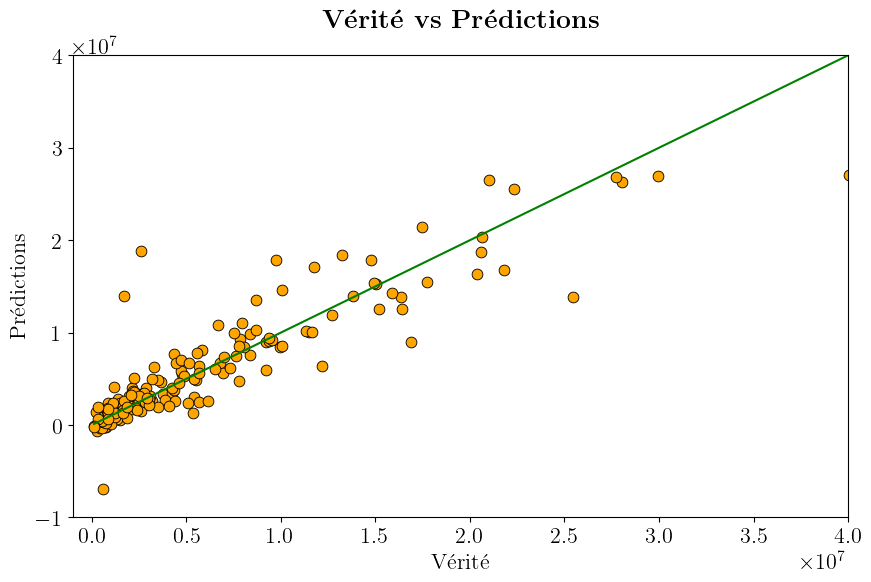

In [93]:
#Scatter-plot predictions vs vérité

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 16)


plt.figure(figsize = (10, 6))
sns.scatterplot(x = y_star_test, y = y_best_pred, color = 'orange', marker='o', edgecolor = 'black', s = 60)
sns.lineplot(x = y_star_test, y = y_star_test, color = 'green', linestyle = '-')
plt.xlim(right = 0.4e8, left = -0.1e7)
plt.ylim(top = 0.4e8, bottom = -1e7)

plt.xlabel('Vérité')
plt.ylabel('Prédictions')
plt.title('\\textbf{{Vérité vs Prédictions}}', pad = 20)
plt.savefig(f"scatter_true_pred.pdf", bbox_inches = 'tight')
plt.show()

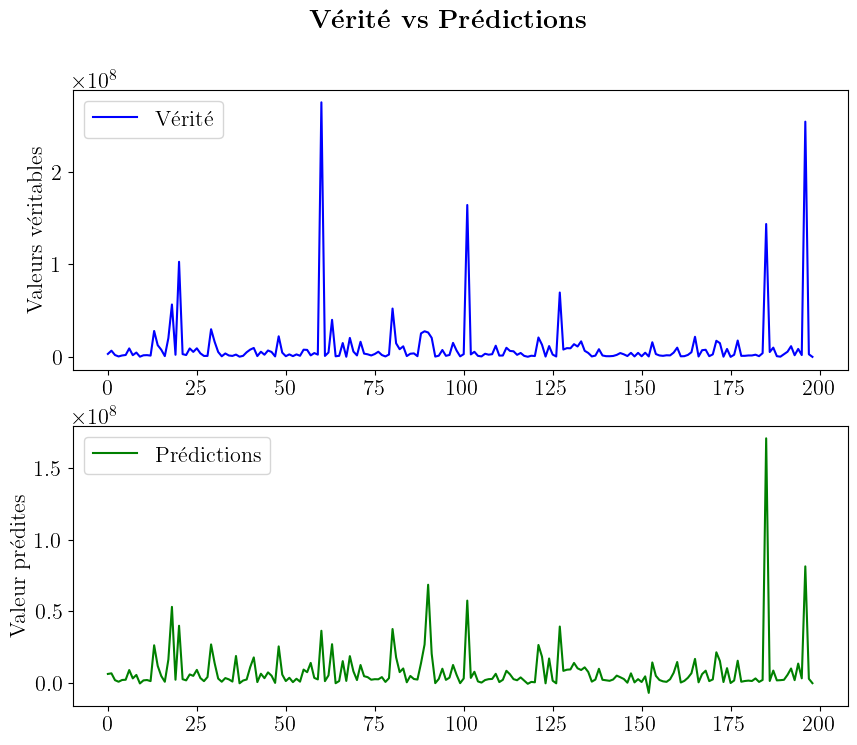

In [95]:
absc = [i for i in range(y_star_test.shape[0])]

fig, axes = plt.subplots(2,1, figsize = (10,8))
sns.lineplot(x = absc, y = y_star_test, color = 'blue', ax = axes[0], label = 'Vérité')
sns.lineplot(x = absc, y = y_best_pred, color = 'green', ax = axes[1], label = 'Prédictions')
axes[0].set_ylabel('Valeurs véritables')
axes[1].set_ylabel('Valeur prédites')
plt.suptitle(f"\\textbf{{Vérité vs Prédictions}}")
plt.savefig(f"lineplot_true_pred.pdf", bbox_inches = 'tight')
plt.show()

In [97]:
#On récupère le nom des colonnes des données prétraitées dans une liste

feature_names = model.steps[0][1].get_feature_names_out().tolist()
feature_names = [feature.replace('num__', '') for feature in feature_names]
feature_names = [feature.replace('cat__', '') for feature in feature_names]


#On récupère l'importance des features

feature_importances = model.steps[1][1].feature_importances_.tolist()

In [107]:
#On crée un dataframe

data_feature_importance = pd.DataFrame({'FEATURE' : feature_names, 'IMPORTANCE' : feature_importances})


#On regroupe les importances par features pour avoir l'importance de la feature de base

categorical_features = ['PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'Neighborhood']
numerical_features = feature_names[0:11]

sum_importances = []

for feature in categorical_features:
    somme = data_feature_importance.loc[data_feature_importance['FEATURE'].str.contains(feature), 'IMPORTANCE'].sum()
    sum_importances.append(somme)

    
data_sum = pd.DataFrame({'FEATURE' : categorical_features, 'IMPORTANCE' : sum_importances})
data_feature_importance = pd.concat([data_feature_importance.loc[data_feature_importance['FEATURE'].isin(numerical_features),:], data_sum])

data_feature_importance.head()

,FEATURE,IMPORTANCE
0,NumberofBuildings,0.265803
1,PropertyGFATotal,0.267326
2,ENERGYSTARScore,0.038764
3,ElectricityProp,0.120804
4,SteamProp,0.005433


In [110]:
#On arrondit, et on trie

data_feature_importance['IMPORTANCE'] = data_feature_importance['IMPORTANCE']*100
data_feature_importance =  data_feature_importance.sort_values(by = 'IMPORTANCE', ascending = False)
data_feature_importance.reset_index(drop = True, inplace = True)

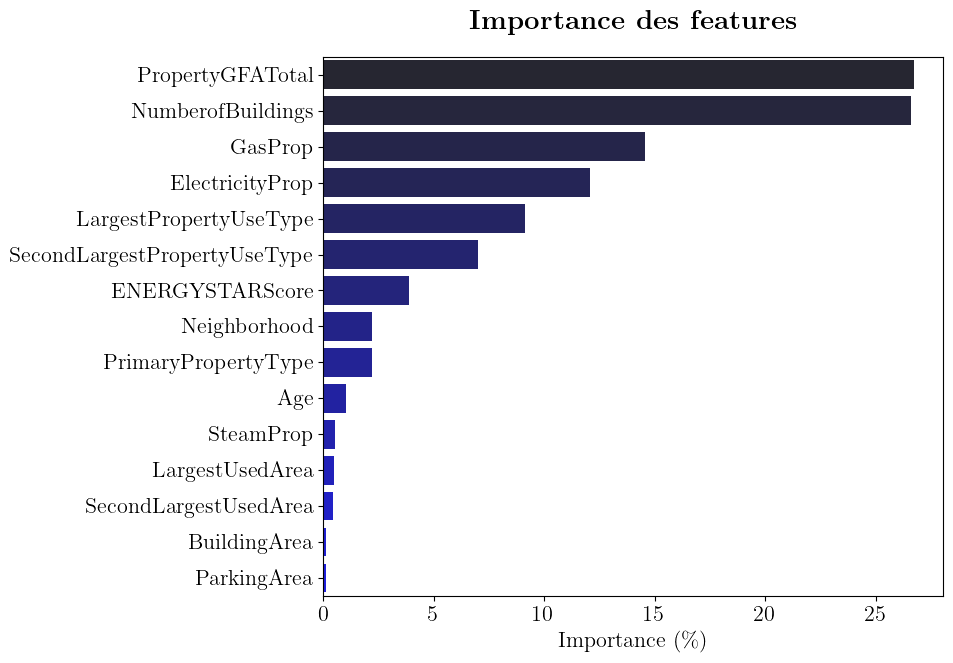

In [113]:
#On plot

plt.rc('text', usetex = True)
plt.figure(figsize=(8, 7))
sns.barplot(y = 'FEATURE', x = 'IMPORTANCE', hue = 'FEATURE', data = data_feature_importance.head(15), palette = 'dark:blue', legend = False)
plt.xlabel('Importance $(\%)$')
plt.ylabel('')
plt.title('\\textbf{Importance des features}', size = 20, pad = 20)
plt.savefig(f"barplot_feature_importance.pdf", bbox_inches = 'tight')
plt.show()

In [116]:
#SHAP

import shap
shap.initjs()

In [118]:
#SHAP

X_train_processed = preprocessor_stdscl.fit_transform(X_star_train)
X_test_processed = preprocessor_stdscl.transform(X_star_test)

estimator = model.steps[-1][1]

explainer = shap.Explainer(estimator, X_train_processed.toarray())
explainer.expected_value

10447406.09287463

In [123]:
#Les shap_values que l'on met en dataframe

shap_values = explainer(X_test_processed.toarray(), check_additivity = False)
shap_df = pd.DataFrame(shap_values.values, columns = feature_names)

shap_df.head()

,NumberofBuildings,PropertyGFATotal,ENERGYSTARScore,ElectricityProp,SteamProp,GasProp,Age,BuildingArea,ParkingArea,LargestUsedArea,...,SecondLargestPropertyUseType_Other - Services,SecondLargestPropertyUseType_Parking,SecondLargestPropertyUseType_Performing Arts,SecondLargestPropertyUseType_Pre-school/Daycare,SecondLargestPropertyUseType_Restaurant,SecondLargestPropertyUseType_Retail Store,SecondLargestPropertyUseType_Self-Storage Facility,SecondLargestPropertyUseType_Supermarket/Grocery Store,SecondLargestPropertyUseType_Swimming Pool,SecondLargestPropertyUseType_Worship Facility
0,-182.366992,-2.949192e+06,-1.911750e+06,9.218642e+05,-20082.097817,1.277696e+06,-31421.309818,69475.920881,69023.104900,6.484187e+05,...,0.0,-4928.278555,0.0,0.0,0.0,-7131.069152,0.0,842.476833,0.0,0.0
1,1156.089277,-7.816804e+06,6.990075e+05,1.012316e+06,-20843.965073,1.358100e+06,-265036.495861,54617.279138,70032.242322,2.900701e+05,...,0.0,1791.337949,0.0,0.0,0.0,-7243.706750,0.0,339.720897,0.0,0.0
2,1156.089277,-7.463183e+06,2.607742e+06,-1.053409e+06,-19225.428586,-5.384533e+05,6534.824432,81733.379524,70666.084331,-1.274337e+06,...,0.0,-12320.696367,0.0,0.0,0.0,-10219.285557,0.0,-28553.431260,0.0,0.0
3,1156.089277,-6.153158e+06,-1.942460e+06,-1.198676e+05,-19073.772339,-6.404487e+05,53864.854699,65282.686936,68487.866306,4.403328e+05,...,0.0,-12320.696367,0.0,0.0,0.0,-10147.849064,0.0,942.114011,0.0,0.0
4,1156.089277,-8.490195e+06,-3.219861e+05,5.456720e+05,-20082.097817,1.120434e+06,103506.417152,69030.497932,68881.999880,5.718475e+05,...,0.0,-12320.696367,0.0,0.0,0.0,-10147.849064,0.0,842.476833,0.0,0.0


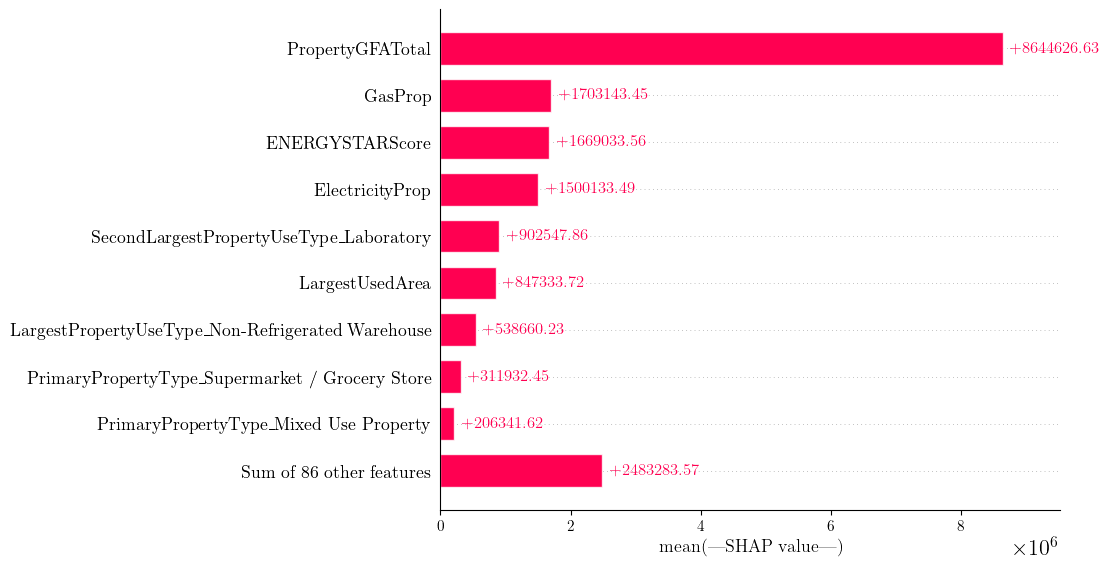

In [132]:
#On rattache le nom des features aux shap_values

shap_values.feature_names = feature_names


#On plot avec SHAP

plt.rc('text', usetex = True)
shap.plots.bar(shap_values)

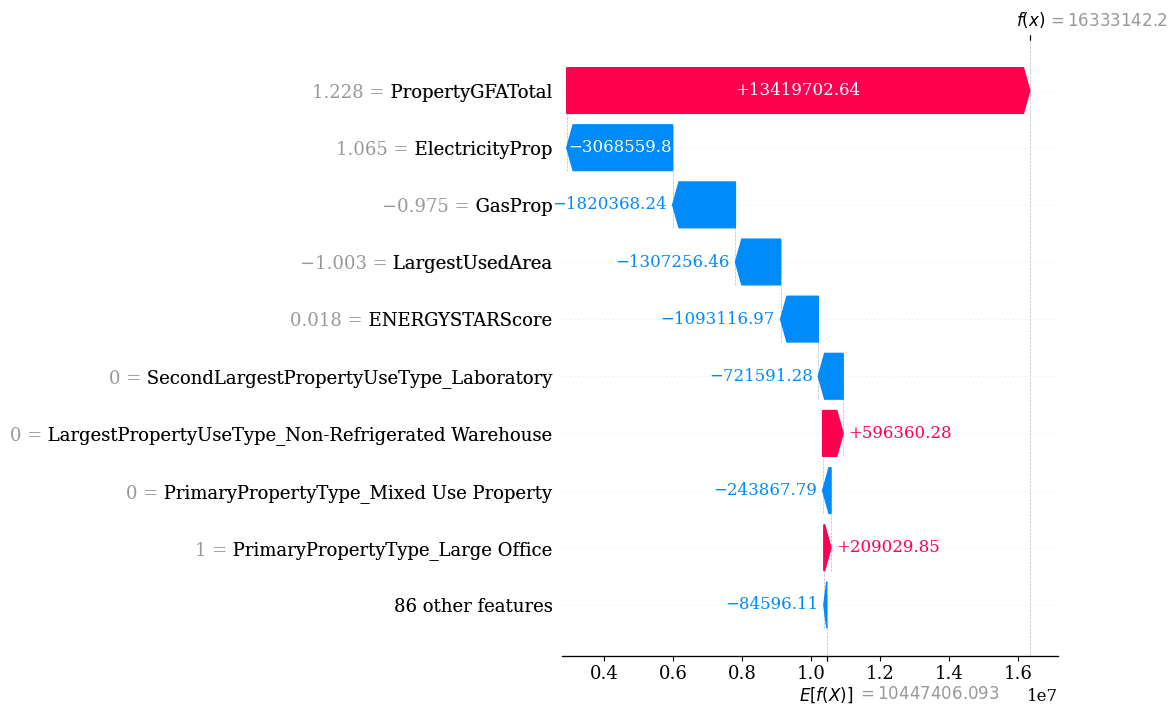

In [173]:
#Le diagramme en cascade 

i = 17
explanation_i = shap.Explanation(values=shap_values[i],
                                  base_values = shap_values.base_values,
                                  data=X_star_train.iloc[i], 
                                  feature_names=feature_names)

plt.rc('text', usetex = False)
plt.rc('font', family = 'serif', size = 12)
#plt.figure(figsize = (12,9))
shap.waterfall_plot(explanation_i, show = False)
w, _ = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(w*0.8, w*1)
# Afficher le graphique
plt.show()

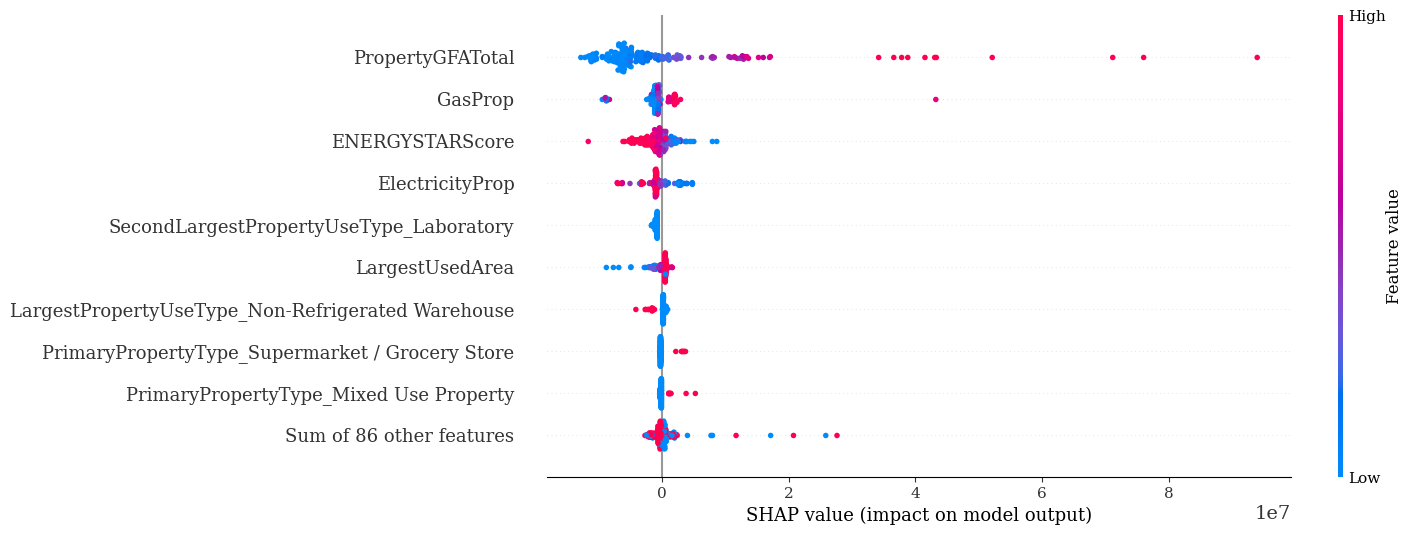

In [145]:
#Et le diagramme en essaim

plt.rc('font', family = 'serif', size = 14)
shap.plots.beeswarm(shap_values, max_display=10, plot_size = (12,6))

In [176]:
#Et enfin le force plot

shap.plots.force(shap_values[0:100])